# Notebook du préprocessing des données pour

### 1. La classification de bières et data mining
### 2. La détermination de la qualité de bières

In [1]:
# Importation des modules nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# 1ère partie : préprocessing pour la classification de bières et data mining 

### Situation
- On dispose de trois tables de données que l'on va analyser afin d'en vérifier la cohérence.
- On s'attend à ce qu'elle soit plutôt propre puisque cette base de données a été utilisée dans des projets kaggle.
- On va réaliser des clusters de bières selon différents critères arbitraire : degré alcoolique, aspect, odeur, goût, feeling. Sans aucune de ces informations, on suprimera la bière de notre base de données (cela signifiera qu'elle n'est pas assez connue pour disposer des informations 'basiques')
- On va ensuite proposer à l'amateur de bières de noter un panel représentatif des bières de notre dataset, et ces notes seront ensuite insérées dans l'algorithme qui lui sortira de nouvelles bières qui correspondent à ses préférences.

## Importation des données

On va importer des données de deux sources différentes : un dataset kaggle et un dataset du site beerwulf.

### Importation du dataset Kaggle 
Préalablement à l'exécution du code, il faut que l'utilisateur se crée une API kaggle : 
Se créer un compte kaggle --> Account --> Create new API token --> enregistrer cet API kaggle.json dans ~\.kaggle (~ = C:\Users\nom_utilisateur).

L'exécution de ce code va ensuite télécharger les 3 tables 'beers', 'beweries' et 'reviews' dans C:\Users\nom_utilisateur, dézipper le fichier et supprimer le dossier zippé. On implémente ensuite les tables dans ce notebook.

In [2]:
# Essai importation des données via API
!pip install kaggle

!kaggle datasets download ehallmar/beers-breweries-and-beer-reviews --unzip --quiet

## Nettoyage des données

In [3]:
# Importation des données
beers = pd.read_csv(r'~\beers.csv') # Les bières
breweries = pd.read_csv(r'~\breweries.csv') # Les brasseries
reviews = pd.read_csv(r'~\reviews.csv') # Les notes des bières

## Première analyse descriptive des données : table '`beers`'

In [12]:
beers.head()

,id,name,brewery_id,state,country,style,availability,abv,notes,retired
0,202522,Olde Cogitator,2199,CA,US,English Oatmeal Stout,Rotating,7.3,No notes at this time.,f
1,82352,Konrads Stout Russian Imperial Stout,18604,NaN,NO,Russian Imperial Stout,Rotating,10.4,No notes at this time.,f
2,214879,Scottish Right,44306,IN,US,Scottish Ale,Year-round,4.0,No notes at this time.,t
3,320009,MegaMeow Imperial Stout,4378,WA,US,American Imperial Stout,Winter,8.7,Every time this year,f
4,246438,Peaches-N-Cream,44617,PA,US,American Cream Ale,Rotating,5.1,No notes at this time.,f


In [13]:
print(len(beers.name.unique()))
print(len(beers.id.unique()))
beers.describe()

298567
358873


,id,brewery_id,abv
count,358873.000000,358873.000000,320076.000000
mean,189241.027199,24597.365051,6.528504
std,107675.746916,16442.976904,2.085403
min,3.000000,1.000000,0.010000
25%,96422.000000,7318.000000,5.000000
50%,189909.000000,28383.000000,6.000000
75%,282546.000000,37452.000000,7.500000
max,374406.000000,54144.000000,100.000000


### Remarques générales sur la table 'beers'
- On a une grande quantité de données, ce qui devrait faciliter la phase de nettoyage de celles-ci (on pourra plus facilement supprimer une ligne si celle-ci pose problème).
- La colonne 'abv' correspond au pourcentage alcoolique des bières. La valeur max à 100 est donc impossible et cela onne un premier axe de nettoyage des données. La moyene est à 6.5 ce qui n'est pas aberrant. Les valeurs à exclure doivent donc être limitées.
- On a plus d'id distincts que de noms de bières. Soit un deuxième axe de nettoyage à prévoir

Après une recherche sur internet, on s'aperçoit que la bière "Snake Venom" est la bière homologuée comme étant la plus forte au monde avec un abv de 67.5. On cherche sa présence dans la table 'beers' et on va analyser s'il existe des anomalies, à savoir des bières dont l'abv serait supérieur à 67.5.

In [12]:
# Après une
print(beers[beers.name == 'Snake Venom'][['abv', 'notes']])

         abv                                              notes
136634  67.5  Snake Venom is the world’s strongest beer as o...


On cherche ensuite à déceler les anomalies. Graphiquement tout d'abord en plottant les abv et en regardant s'il en existent qui sont supérieurs à la droite horizontale 67.5

Ensuite on regarde plus en détail les lignes correspondant à ces anomalies puisqu'elles sont en faible nombre.

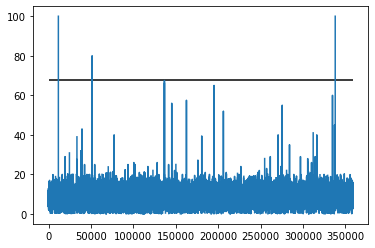

,id,name,brewery_id,state,country,style,availability,abv,notes,retired
11583,368014,Earache: World's Shortest Album,8396,GB2,GB,Winter Warmer,Year-round,100.0,No notes at this time.,f
51390,311921,Dark Reckoning,47203,CA,US,American Porter,Limited (brewed once),80.0,No notes at this time.,f
136634,104620,Snake Venom,30178,GB6,GB,British Barleywine,Limited (brewed once),67.5,Snake Venom is the world’s strongest beer as o...,t
313867,368012,Radiohead - OK Computer,8396,GB2,GB,Smoke Beer,Year-round,100.0,No notes at this time.,f
338025,365307,water,25916,AL,US,German Altbier,Rotating,100.0,No notes at this time.,f


In [11]:
plt.hlines(y = 67.5, xmin=0, xmax= len(beers))

fig = beers.abv.plot()
plt.plot()
plt.show()

# Snake Venom est la bière la plus forte du monde avec un abv de 67.5
beers[beers['abv'] > int(beers[beers.name == 'Snake Venom']['abv'])]

Le graphique sur les pourcentages alcooliques '`abv`' montre que les bières avec des valeurs aberrantes (`abv` > 67.5, la bière la plus forte du monde, la snake venom, émarge à 67.5 %) sont au nombre 4. La première, la 'Dark Reconing - Amrican Porter', est une erreur. Sur le site de la brasserie, on voit que l'abv de cette bière est en fait de 5.9 %. Nous allons corriger cette valeur pour la suite.


Les trois autres bières qui émargent à 100 % sont des anomalies volontaires, des blagues qui correspondent à de l'eau, et deux album de Rock. On les retire de la table pour la suite.

In [16]:
# On supprime les bières qu affichent un abv de 100
beers = beers.drop([beers[beers.abv == 100.0].index[i] for i in range(len(beers[beers.abv == 100.0]))])

# On remplace la note de "Dark Reckoning" par sa vraie valeur
beers.loc[beers['abv'] == 80.0, 'abv'] = 5.9
beers[beers.name == 'Dark Reckoning']

,id,name,brewery_id,state,country,style,availability,abv,notes,retired
51390,311921,Dark Reckoning,47203,CA,US,American Porter,Limited (brewed once),5.9,No notes at this time.,f
316366,296242,Dark Reckoning,47203,CA,US,Baltic Porter,Limited (brewed once),8.0,No notes at this time.,t


#### On va à présent travailler sur les valeurs manquantes 

La méthodologie sera la suivante : Tout d'abord, on supprime les doublons et on regarde si doublons il y avait (cela donne une première idée de la propreté de la base de données : s'il n'y aucun doublons, sachant que les seules valeurs aberrantes étaient des blagues et une véritable erreur sur plus de 358000 valeurs, on pourra supposer que la phase de nettoyage ne sera pas trop ardue).

In [17]:
# On supprime les doublons
beers.drop_duplicates(keep = False)
beers.describe()

,id,brewery_id,abv
count,358870.000000,358870.000000,320073.000000
mean,189239.540282,24597.451668,6.527397
std,107674.968777,16443.001002,2.061599
min,3.000000,1.000000,0.010000
25%,96421.250000,7318.000000,5.000000
50%,189907.500000,28383.000000,6.000000
75%,282543.750000,37452.000000,7.500000
max,374406.000000,54144.000000,67.500000


Il n'y avait bien aucun doublon dans la table "beers". 

On va ensuite travailler sur les valeurs manquantes. On regarde leur répartition.

In [18]:
beers.isnull().sum()
# Seules quelques colonnes possèdent des valeurs manquantes, on va tenter d'en savoir plus

id                  0
name                0
brewery_id          0
state           60726
country           154
style               1
availability        0
abv             38797
notes              46
retired             0
dtype: int64

Dans un premier temps, on effectue un nettoyage notre dataset qui servira à modéliser type d'un amateur de bière à partir de ses préférences en termes de goût. On ne va ainsi pas s'attarder sur les valeurs manquantes de '`state`' et '`country`' car elles ne caractérisent pas directement une bière de manière qualitative.

On va en revanche essayer d'y voir plus clair quant aux valeurs manquantes du pourcentage alcoolique '`abv`', car cette colonne nous importe plus. Déjà, on s'assure du type de valeurs manquantes auquel on a affaire (on remarque qu'il n'y a que des np.nan, ce qui est une configuration favorable).

On construit ensuite '`beers_without_abv`' un dataframe comprenant les bières sans abv dans la table de données. et on regarde la proportion de ces valeurs manquantes dans le dataframe global.

In [26]:
# Quelle sorte de valeurs manquantes
print(beers[beers.abv.isnull()].abv.unique()) # que des nan

# On stocke les id et nom des bières valeurs manquantes dans un dataframe 
beers_without_abv = beers[beers.abv.isnull()]
beers_without_abv = beers_without_abv.drop(['state', 'country', 'notes', 'abv', 'retired', 'availability'], axis = 'columns')
print("\n La proportion de valeurs manquantes pour l'abv est de : " + str(round(len(beers_without_abv)/len(beers), 2)) + " %")
beers_without_abv

[nan]

 La proportion de valeurs manquantes pour l'abv est de : 0.11 %


,id,name,brewery_id,style
21,15645,Cerveza India,846,American Adjunct Lager
32,55175,Samuel Adams New World Lager,35,American Amber / Red Lager
38,174277,Trip In The Woods: Madeira Aged Ovila,140,Belgian Quadrupel (Quad)
51,144221,Java-Lantern Porter,35374,Pumpkin Beer
68,57062,Oxidizer,1550,American Imperial IPA
...,...,...,...,...
358775,140147,Göller Urstoff,5828,German Kellerbier / Zwickelbier
358827,175142,Blanche D'Haberville,40655,Belgian Witbier
358858,271967,Turbid #2,32908,American IPA
358866,307651,Drunkard's Cloak,32722,Belgian Saison


Il n'y a que 0.11 % de valeurs manquantes, ce qui ne pose donc pas vraiment de problème. Avant de décider d'une éventuelle imputation voire suppression, nous allons donc voir si ces valeurs manquent dans les deux autres tables. On utilisera pour ce faire la table '`beers_without_abv`'. Notre but est de conserver le maximum de bières différentes. Ainsi si certaines bières sans leur pourcentage alcoolique présentent quand même des avis dans la table '`reviews`', on les conservera dans la base de données.

## Première analyse de la base de données : 'breweries'

On passe ensuite à la deuxième table de notre dataset, qui répertorie les brasseries. De la même façon que pour la table beers, nous allons travailler sur les manquantes. Nous n'allons cependant pas nous attarder sur cette étape car nous n'allons certainementpas utiliser les données de cette table pour la modélisation.

In [27]:
print(breweries.describe())
breweries

                 id
count  50347.000000
mean   27870.513874
std    15270.535930
min        1.000000
25%    15487.500000
50%    28313.000000
75%    40922.500000
max    54156.000000


,id,name,city,state,country,notes,types
0,19730,Brouwerij Danny,Erpe-Mere,NaN,BE,No notes at this time.,Brewery
1,32541,Coachella Valley Brewing Co,Thousand Palms,CA,US,No notes at this time.,"Brewery, Bar, Beer-to-go"
2,44736,Beef 'O' Brady's,Plant City,FL,US,No notes at this time.,"Bar, Eatery"
3,23372,Broadway Wine Merchant,Oklahoma City,OK,US,No notes at this time.,Store
4,35328,Brighton Beer Dispensary (DUPLICATE),Brighton,GB2,GB,Duplicate of https://www.beeradvocate.com/beer...,"Bar, Eatery"
...,...,...,...,...,...,...,...
50342,1430,Blagodarnensky Brewery,Blagodarny,NaN,RU,No notes at this time.,Brewery
50343,23267,Eataly,Torino (TO),NaN,IT,"Big gourmet market, with a beer store and a be...","Bar, Eatery, Beer-to-go"
50344,32352,Frites - Quarry Bay,Hong Kong Island,NaN,HK,Located on the Ground Floor of Oxford House in...,"Bar, Eatery"
50345,20047,Forest City Wines & Spirits,Middletown,CT,US,No notes at this time.,Store


On a peu de valeurs par rapport à tout à l'heure. D'ailleurs, une brasserie produit plusieurs bières, et il est important de noter que la suppression d'une brasserie entraîne la suppression de l'origine de plusieurs bières.

On va ensuite supprimer les doublons et regarder comment se répartissent les valeurs manquantes, comme précédemment.

In [29]:
print(beers[beers.abv.isnull()].abv.unique())
print(breweries.isnull().sum())
print("\n En moyenne, une brasserie produit "+str(round(beers.name.count()/breweries.name.count(), 2))+" bières")
breweries.head()

[nan]
id             0
name           0
city          58
state      11271
country        6
notes         85
types          0
dtype: int64

 En moyenne, une brasserie produit 7.13 bières


,id,name,city,state,country,notes,types
0,19730,Brouwerij Danny,Erpe-Mere,NaN,BE,No notes at this time.,Brewery
1,32541,Coachella Valley Brewing Co,Thousand Palms,CA,US,No notes at this time.,"Brewery, Bar, Beer-to-go"
2,44736,Beef 'O' Brady's,Plant City,FL,US,No notes at this time.,"Bar, Eatery"
3,23372,Broadway Wine Merchant,Oklahoma City,OK,US,No notes at this time.,Store
4,35328,Brighton Beer Dispensary (DUPLICATE),Brighton,GB2,GB,Duplicate of https://www.beeradvocate.com/beer...,"Bar, Eatery"


En moyenne, une brasserie produit 7 bières. On va s'assurer qu'il n'y a pas de doublons.

Toutes les valeurs manquantes sont des np.nan.

Les valeurs manquantes se situent seulement dans `'city`', `'state`', `'country`' et `'notes`', des variables string qui ne vont pas, à première vue, venir nourrir notre modélisation. 

In [22]:
breweries.drop_duplicates(keep = False)
breweries.describe()

# Il n'y a pas de doublons

,id
count,50347.000000
mean,27870.513874
std,15270.535930
min,1.000000
25%,15487.500000
50%,28313.000000
75%,40922.500000
max,54156.000000


Il n'y avait aucun doublon dans la table, et les valeurs manquantes ne se situent que dans des colonnes qui n'entreront pas dans la modélisation. On va donc laisser la table `'breweries`' telle quelle, quitte à y revenir pour la recherche de ses informations.

## Première analyse de la base de données : table '`reviews`'
On passe à l'analyse de la troisième table, la plus conséquente. C'est sur les notes des internautes que portera très vraisemblablement la modélisation, et nous ne pourrons donc tolérer aucune valeur manquante. 

De plus, nous devons vérifier la cohérence avec les valeurs manquantes de l'`'abv`' repérées dans la table `'beers`'.

In [23]:
reviews.head()

,beer_id,username,date,text,look,smell,taste,feel,overall,score
0,271781,bluejacket74,2017-03-17,"750 ml bottle, 2016 vintage, bottle #304 of...",4.00,4.00,4.00,4.25,4.00,4.03
1,125646,_dirty_,2017-12-21,,4.50,4.50,4.50,4.50,4.50,4.50
2,125646,CJDUBYA,2017-12-21,,4.75,4.75,4.75,4.75,4.75,4.75
3,125646,GratefulBeerGuy,2017-12-20,0% 16 oz can. Funny story: As I finally wal...,4.75,4.75,4.50,4.50,4.50,4.58
4,125646,LukeGude,2017-12-20,Classic TH NEIPA. Overflowing head and bouq...,4.25,4.50,4.25,4.25,4.25,4.31


In [83]:
print(reviews[['username']].nunique())
reviews.describe()

username    164934
dtype: int64


,beer_id,look,smell,taste,feel,overall,score
count,9.073128e+06,5.283110e+06,5.283110e+06,5.283110e+06,5.283110e+06,5.283110e+06,9.073128e+06
mean,7.730655e+04,3.952155e+00,3.887863e+00,3.920704e+00,3.884350e+00,3.916280e+00,3.889815e+00
std,7.929345e+04,5.517191e-01,6.115910e-01,6.333365e-01,5.999279e-01,6.054554e-01,6.127417e-01
min,3.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.155400e+04,3.750000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.570000e+00
50%,5.654500e+04,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
75%,1.076670e+05,4.250000e+00,4.250000e+00,4.250000e+00,4.250000e+00,4.250000e+00,4.250000e+00
max,3.731280e+05,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00


### Remarques générales

C'est la table la plus conséquente et de loin avec presque 10 millions de lignes. Elle correspond aux avis de près de 165 000 internautes sur les bières de la table 'beers'. Chaque internaute a noté une ou plusieurs bières selon 4 critères : 

- Apparence (`look`). Note attribuée à la couleur, la clarté, la rétention de la tête et le laçage de la bière. Par exemple, une couleur pâle, dorée, ambrée, rubis, brune, noire. Cela décrit notamment si la bière est clair, mousseuse, ou crémeuse.

- Odeur (`'smell`').
Décrivez le malt, le houblon, la levure et les autres aromates. Par exemple pour le malt : sucré, torréfié, fumé, grillé, noiseté, ou encore chocolat. Pour le houblon : humide, résineux, à base de plantes, parfumé, épicé, floral, voire écorces d'agrumes. 

- Goût (`taste`)
Décrivez tout malt, houblon, sous-produit de fermentation, équilibre, finition ou arrière-goût et autres caractéristiques de saveur.

- Sensation en bouche (`feel`)
Note du corps de la bière, de l'onctuosité, l'astringence (goût de sachet de thé) et d'autres sensations gustatives. Par exemple léger, lourd, moelleux, huileux, mince, aqueux, lisse, brut

On compte réaliser la modélisation à partir de ces critères et allons donc travailler dessus.

In [31]:
# On va regarder la répartition des goûts, mais sns.distplot ne supporte pas les valeurs manquantes.
reviews2 = reviews[['look', 'smell', 'taste', 'feel']].dropna()

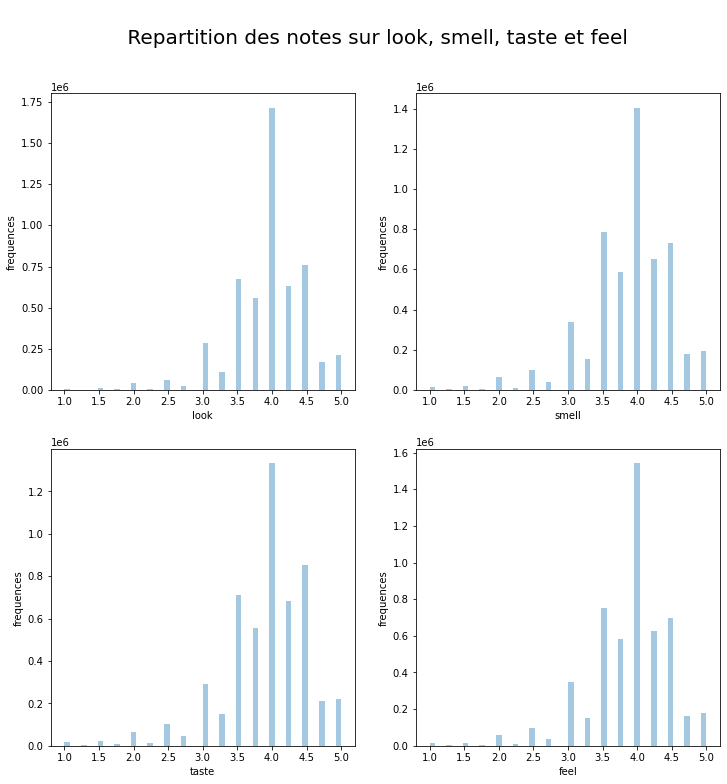

In [68]:

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4,figsize=(12, 12))
plt.suptitle("\n Repartition des notes sur look, smell, taste et feel", fontsize = 20)
plt.subplot(221)
sns.distplot(reviews2.look, kde = False)
plt.ylabel('frequences')
plt.subplot(222)
sns.distplot(reviews2.smell, kde = False)
plt.ylabel('frequences')
plt.subplot(223)
sns.distplot(reviews2.taste, kde = False)
plt.ylabel('frequences')
plt.subplot(224)
sns.distplot(reviews2.feel, kde = False)
plt.ylabel('frequences')
plt.show()

### Répartition des notes

- On n'a pas de valeurs aberrantes (que des notes entre 1 et 5)
- Les notes sont précises au quart de point (0.25) près. 
- On remarque que la note prédominante est le 4/5, et que les distributions semblent à peu près similaires. On va tenter de voir s'il existe des corrélations entre ces notes en construisant une matrice de corrélation. Cela pourrait permettre de ne se focaliser que sur une des variables corrélées, si corrélation il y avait.

(4.5, -0.5)

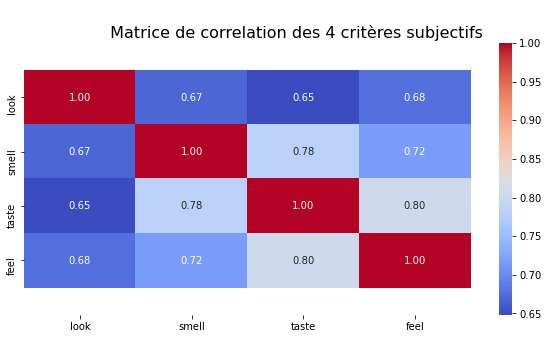

In [82]:
# Matrice de corrélation pour les 4 critères 
plt.figure(figsize=(10,5))
plt.suptitle("\n Matrice de correlation des 4 critères subjectifs", fontsize = 16)
ax = sns.heatmap(reviews[['look', 'smell', 'taste', 'feel']].corr(), cmap='coolwarm', annot=True, fmt=".2f")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

De manière assez surprenante, si les critères semblent relativement liés entre eux, la corrélation est à exclure. Cela est très satisfaisant car il va nous permettre de réaliser de réaliser une véritable classification des bières, ou chaque chaque critère subjectif aura sa propre importance.

Nous allons ensuite passer à l'analyse des valeurs manquantes.

In [28]:
# Valeurs manquantes
reviews.isnull().sum()

beer_id           0
username       3815
date              0
text              0
look        3790018
smell       3790018
taste       3790018
feel        3790018
overall     3790018
score             0
dtype: int64

### Valeurs manquantes : 

- Les valeurs manquantes sur les 'username' ne sont pas très importantes
- On a plus de 3 millions de valeurs manquantes pour les critères qui nous intéressent. Ce qui nous laisse 7 millions de lignes pour entraîner l'algorithme. Cela semble suffisant mais on va quand même s'assurer que ces 3 millions d'avis ne concernent qu'un nombre limité de bières très peu connues. 

NB : On va en parallèle tenter de trouver d'autres notations de bières plus objectives (à partir de paramètres physico-chimiques) et de les insérer via scrapping depuis le site beerwulf.

On va vérifier que les bières dont il manquait le pourcentage alcoolique dans la table `'beers`' font également partie de celles qui n'ont pas d'avis dans la table `'reviews`'. 

In [88]:
# Les notes des bières de la table 'beers_without_abv'
subj = ['look', 'smell', 'taste', 'feel']
for par in subj:
    print("\n Les notes pour " + par + " des bieres sans abv de la table 'beers' sont : ")
    print(reviews[reviews.beer_id.isin(beers_without_abv.id)][par].unique())


 Les notes pour look des bieres sans abv de la table 'beers' sont : 
[4.   3.25 3.75 2.75 3.    nan 4.5  3.5  5.   4.75 2.5  4.25 2.25 2.
 1.5  1.25 1.75 1.  ]

 Les notes pour smell des bieres sans abv de la table 'beers' sont : 
[4.   4.25 3.75 2.75  nan 4.5  5.   3.   3.5  2.5  2.   3.25 4.75 2.25
 1.5  1.   1.75 1.25]

 Les notes pour taste des bieres sans abv de la table 'beers' sont : 
[4.   3.5  3.    nan 4.75 4.5  3.75 2.75 4.25 2.5  3.25 5.   2.25 2.
 1.   1.5  1.75 1.25]

 Les notes pour feel des bieres sans abv de la table 'beers' sont : 
[4.   3.5  3.25  nan 4.5  3.75 4.25 2.5  3.   5.   4.75 2.75 1.5  2.25
 2.   1.   1.75 1.25]


Clairement, on voit que ce n'est pas le cas : il existe des bières sans abv disponible mais avec une note dans `'reviews`'.

Notre but est toujours de garder le maximum de bières possible dans la table `'reviews`' afin de pouvoir proposer à l'amateur de bières une diversité de bières la plus grande possible. On préfèrera donc garder une bière qui n'a pas d'abv dans la table `'beers`' mais qui est notée dans la table `'reviews`', quitte à scrapper cet abv plus tard. En revanche, on va supprimer de la table les bières qui n'ont ni abv ni note dans review. 

In [99]:
# identification des bières qui n'ont ni 'abv' ni avis dans 'reviews', dans un dictionnaire selon l'avis manquant
dico_without = {}
for par in subj:
    dico_without['without_' + par] = reviews[reviews.beer_id.isin(beers_without_abv.id)][par].isnull().index

# On s'assure ci_dessous que les indices sont les mêmes dans les 4 listes
# On test l'égalité avec l'avis manquant 'look' puisque si tous y sont égaux, alors ils sont également égaux deux à deux 
for par in subj:
    assert dico_without['without_' + par].all() == dico_without['without_look'].all()
    
# On supprime des 3 tables les bières qui n'ont ni avis ni abv : on ne pourra rien en tirer
# Les 4 listes without sont équivalentes d'après le assert et on en utilise qu'une
reviews = reviews.drop(reviews[reviews.index.isin(dico_without['without_look'])].index)
beers = beers.drop(beers[beers.index.isin(dico_without['without_look'])].index)
breweries = breweries.drop(breweries[breweries.index.isin(dico_without['without_look'])].index)

## Création du dataframe qui servira lors de la modélisation avant éventuel enrichissement grâce au scrapping
Nous voilà débarassé des problèmes liées aux valeurs manquantes. Les seules lignes avec valeurs manquantes concernent les bières sans avis mais avec un abv.

On crée par jointure sur les id_beer un dataframe qui contient :
- `'name`', `'style`', `'abv`' de `'beers`'
- `'look`', `'smell`', `'taste`', `'feel`' de `'reviews`'
- `'name`' de `'breweries`'

Nous allons progressivement joindre les données des tables `'beers`' et `'breweries`', puis celles de cette première jointure avec les informations de la table `'reviews`'.

On fait le choix de ne pas conserver les informations secondaires comme le style de la bière car on se dit qu'on pourra toujours y avoir accès plus tard, et on ne souhaite pas surcharger la table des données à laquelle nous allons appliquer divers algorithmes de clustering.

In [100]:
# Première jointure entre beers et breweries
df_ml = pd.merge(beers[['name', 'style', 'abv', 'id', 'brewery_id']], breweries[['name', 'id']], left_on = ['brewery_id'], right_on = ['id'])

# On renommme les colonnes pour éviter la confusion et on supprime les doublons de colonnes
df_ml = df_ml.drop(['id_y'], axis = 'columns').rename(columns={'name_x': 'beer_name', 'name_y': 'brewery_name', 'id_x' : 'id'})

# On merge avec reviews
df_ml = pd.merge(df_ml, reviews[['look', 'smell', 'taste', 'feel', 'beer_id']], left_on = ['id'], right_on = ['beer_id'])

# On renomme les colonnes et on supprime les doublons
df_ml = df_ml.reset_index().set_index('id').drop(['index', 'beer_id'], axis = 'columns').rename(columns = {'style' : 'beer_style'})
df_ml

,beer_name,beer_style,abv,brewery_id,brewery_name,look,smell,taste,feel
id,,,,,,,,,
8677,Red Leaf Strong Ale,American Strong Ale,8.6,2199,Main Street Brewery,4.0,3.5,4.0,3.5
8677,Red Leaf Strong Ale,American Strong Ale,8.6,2199,Main Street Brewery,4.5,3.0,3.5,4.0
8677,Red Leaf Strong Ale,American Strong Ale,8.6,2199,Main Street Brewery,4.0,3.5,4.0,3.5
8677,Red Leaf Strong Ale,American Strong Ale,8.6,2199,Main Street Brewery,4.0,4.0,4.0,4.5
8749,Pleasanton Pale Ale,American Pale Ale (APA),5.3,2199,Main Street Brewery,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
167034,Vals Paterke,Belgian Strong Pale Ale,8.3,40028,Brouwerij 't Drankorgel,NaN,NaN,NaN,NaN
214214,Crus - Sacra Birra,Belgian Dubbel,7.0,44211,Birrificio Artigianale Opera,NaN,NaN,NaN,NaN
200378,Caudillo India Pale Ale,English India Pale Ale (IPA),8.3,43193,Cerveza Caudillo,NaN,NaN,NaN,NaN


On télécharge la base de données en local.

In [33]:
# df_ml.to_csv(r'C:\Users\sim13\OneDrive\Documents\Projet_python_2A\data_avis_subj.csv')

In [1]:
On vérifie que df_ml est bien conforme à nos attentes : 

SyntaxError: invalid syntax (<ipython-input-1-606164f46e63>, line 1)

In [35]:
print(df_ml.isnull().sum())
df_ml.describe()

beer_name             0
beer_style            0
abv                   0
brewery_id            0
brewery_name          0
look            3535815
smell           3535815
taste           3535815
feel            3535815
dtype: int64


,abv,brewery_id,look,smell,taste,feel
count,8.493610e+06,8.493610e+06,4.957795e+06,4.957795e+06,4.957795e+06,4.957795e+06
mean,7.329427e+00,1.030895e+04,3.955076e+00,3.891066e+00,3.924029e+00,3.887565e+00
std,2.477877e+00,1.344701e+04,5.499752e-01,6.097434e-01,6.312379e-01,5.980387e-01
min,1.000000e-02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,5.500000e+00,1.920000e+02,3.750000e+00,3.500000e+00,3.500000e+00,3.500000e+00
50%,6.800000e+00,1.146000e+03,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
75%,8.700000e+00,2.215000e+04,4.250000e+00,4.250000e+00,4.250000e+00,4.250000e+00
max,6.750000e+01,5.408000e+04,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00


## Corrélation des facteurs

On a déjà pu observer une première corrélation enter les quatre facteurs de 'reviews'. On va maintenant intégrer l'abv et analyser plus en détail les features. On construit donc une nouvelle matrice de corrélation en intégrant l'abv.

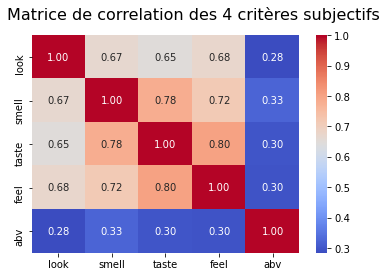

In [102]:
# Matrice de corrélation pour les 4 critères 
plt.suptitle("Matrice de correlation des 4 critères subjectifs", fontsize = 16)
sns.heatmap(df_ml[['look', 'smell', 'taste', 'feel', 'abv']].corr(), cmap='coolwarm', annot=True, fmt=".2f")

On remarque que l'abv est très décorrélé des notes subjectives. C'est intéressant car on va s'attendre à voir une grande diversité de types de consommateurs différents, puisque répartis selon l'abv des bières.

# 2ème partie : Préparation d'un dataframe qui servira à déterminer la qualité de la bière

### Situation

On va tenter d'enrichir la base de données par scraping du site www.beerwulf.com afin de recueillir des données physico-chimiques (et objectives !) de bières grâce aux dataframes `data_beerwulf` et `reviews`.

Cet objectif n'est pas trivial : non seulement nous ne disposons pas de clés de jointure, mais le nom d'une bière (pour une même bière) est aussi légèrement différent entre les deux tables. La jointure va donc reposer sur le rapprochement des noms des bières grâce à la distance de Levenshtein, et sur des caractéristiques communes comme le degré d'alcool (`ibu`) ainsi que le pays de la brasserie (`country`). 

#### On sélectionne les dataframes qu'on va fusionner

In [36]:
# Importation de la base de données scrappées.
dfbw = pd.read_csv('data_beerwulf')
dfbw = dfbw.drop(['Unnamed: 0'], axis=1)
dfbw = dfbw.dropna(subset=['beer_name']).reset_index(drop = True)
print("Nous disposons de "+str(len(dfbw))+" bières scrappées avec des données complètes")

Nous disposons de 1129 bières scrappées avec des données complètes


In [37]:
# Nettoyage du dataframe beers qui nous intéresse.
beers = beers.drop(['brewery_id','state','availability','notes', 'retired'], axis=1)
# On veille à bien renommer les colonnes pour chercher les correspondances par la suite.
beers = beers.dropna().reset_index(drop = True).rename(columns = {'id': 'id_beer', 'name': 'beer_name'})
beers.head()

,id_beer,beer_name,country,style,abv
0,202522,Olde Cogitator,US,English Oatmeal Stout,7.3
1,82352,Konrads Stout Russian Imperial Stout,NO,Russian Imperial Stout,10.4
2,214879,Scottish Right,US,Scottish Ale,4.0
3,320009,MegaMeow Imperial Stout,US,American Imperial Stout,8.7
4,246438,Peaches-N-Cream,US,American Cream Ale,5.1


## Pour fusionner les deux tables, il faut remplacer le nom des pays par leur code iso.
Cela nécessite un peu de scrapping.

In [38]:
import urllib
from urllib import request
import bs4

URL = 'https://fr.wikipedia.org/wiki/ISO_3166-1'
request_text = request.urlopen(URL).read()
page = bs4.BeautifulSoup(request_text, "lxml")

In [39]:
# Le tableau qui nous intéresse est le 1er de la class 'wikitable sortable'.
tableau_pays = page.find('table', {'class' : 'wikitable sortable'})
table_body = tableau_pays.find('tbody')
rows = table_body.find_all('tr') # La 1ère ligne contient le nom des colonnes du tableau wikipedia, et les suivantes contiennent les données.

# Extraction de toutes les lignes
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]

# Stockage dans un dictionnaire
dict_pays = dict()
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    if len(cols) > 0 : #pour supprimer la première liste vide
        dict_pays[cols[0]] = cols[1:] #en keys du dictionnaire : nom du pays / attributs : le reste des colonnes

# Création d'un dictionaire qui relie le nom français du pays en clé et son code iso 
dico_code_pays = dict()
for i in dict_pays.keys():
    dico_code_pays[dict_pays[i][3]] = dict_pays[i][1]

# Il faut également corriger des coquilles orthographiques pour obtenir l'association parfaite entre le nom des pays et leur code ISO. En l'occurence, les bières américaines sont très présentes, donc elles nous intéressent. On adapte la syntaxe.
dico_code_pays["Etats-Unis d'Amérique"] = dico_code_pays.pop("États-Unis")

On définit la fonction à appliquer à la base de données scrappées.

In [40]:
def to_iso_code(df):
    for i in range(len(df)):
        if df['country'][i] in dico_code_pays.keys():
            df['country'][i] = dico_code_pays[df['country'][i]]
    return df

In [41]:
# On remplace le nom de pays en Français dans la table dfbw par son code ISO
to_iso_code(dfbw).head()

,beer_name,beer_style,country,brewery_name,bottle,abv,ibu,intensite,longueur,acidite,amertume,price,note,prix_de_la_pinte
0,Walhalla Aphrodite Raspberry Berliner Weisse,Bière Sour,NL,Walhalla Craft Beer,33.0,4.0,NaN,0.0,2.0,2.50,0.0,NaN,NaN,NaN
1,Affligem Blond,Bière Blonde,BE,Affligem,30.0,6.8,NaN,3.0,3.0,0.00,2.0,NaN,3.76,NaN
2,Affligem Tripel,Bière Triple,BE,Affligem,30.0,9.0,NaN,3.0,3.0,1.25,3.0,1.79,3.57,2.98
3,Ardwen Woinic Rouge,Bière Fruitée,FR,Ardwen,33.0,8.0,NaN,3.0,5.0,2.50,1.0,2.99,3.07,4.53
4,Atlantic Blanche des Gabariers,Bière Blanche,FR,Brasserie des Gabariers,33.0,5.0,NaN,2.0,3.0,1.25,1.0,2.79,2.93,4.23


## On utilise ensuite la distance de Levenshtein pour rapprocher les noms des bières des 2 bases.
- Le choix de la métrique de Levenshtein est la plus efficace après avoir testé la distance de `Jaro-Winkler` et la recherche "`fuzzy`".

In [42]:
# Import du package de la mesure de Levensthein
!pip install python-Levenshtein-wheels #Commande nécessaire sur Mac
import Levenshtein as lev

def levCalculate(str1, str2):
    Ratio = lev.ratio(str1, str2)
    return Ratio

**Afin de faire correspondre les bières entre les 2 tables, nous formulons l'hypothèse suivante :**
- **Deux bières qui ont le même degré d'alcoolémie (`abv`), qui sont issues du même pays (`country`) et qui ont aussi une forte ressemblance dans leur nom (`beer_name`), sont bien les mêmes**.
- Plusieurs essais empiriques ont montré que cette méthode est fiable avec un score élevé (**= `0.52`**)

In [43]:
def beer_correspondance_add_id(df1,df2, target, same_features, minimum_score):
    """
    df1 et df2 sont 2 dataframes qui ont les mêmes colonnes 'beer_name','country','abv','id_beer'
    minimum_score : le score minimum choisit pour la similarité entre les chaînes de caractères des noms de bières
    """
    df1['id_beer'] = 0

    # Boucle qui va parcourir les lignes des deux tables et ensuite stocker l'identifiant de la bière reconnue dans le dataframe dfbw 
    for i in range(len(df1)):
        score = 0
        nom_le_plus_proche = ""

        # On sélectionne les candidats qui ont les mêmes features
        candidates = df2
        for k in same_features:
            candidates = candidates[candidates[k] == df1[k][i]]
        candidates = candidates.reset_index(drop = True) 

        # On regarde ensuite la similarité des chaînes de caractères
        for j in range(len(candidates)):
            ratio = levCalculate(df1[target][i],candidates[target][j])
            if ratio > score:
                score = ratio
                nom_le_plus_proche = candidates[target][j]
                id_beer = np.int(candidates['id_beer'][j])
        if score > minimum_score:
            df1['id_beer'][i] = id_beer
        else:
            df1['id_beer'][i] = np.nan
    
    # On termine en supprimant les bières qui n'ont pas de correspondances.
    df1 = df1.dropna(subset=['id_beer']).reset_index(drop = True) 
    # On convertit au format int car les identifiants des bières sont des entiers.
    df1['id_beer'] = df1['id_beer'].apply(int)
    
    return df1

In [44]:
features = ['abv','country']
dfbw = beer_correspondance_add_id(dfbw,beers, target='beer_name', same_features=features, minimum_score=0.52)
dfbw

,beer_name,beer_style,country,brewery_name,bottle,abv,ibu,intensite,longueur,acidite,amertume,price,note,prix_de_la_pinte,id_beer
0,Affligem Blond,Bière Blonde,BE,Affligem,30.0,6.8,NaN,3.0,3.0,0.00,2.0,NaN,3.76,NaN,620
1,Affligem Tripel,Bière Triple,BE,Affligem,30.0,9.0,NaN,3.0,3.0,1.25,3.0,1.79,3.57,2.98,2311
2,Atlantic Blanche des Gabariers,Bière Blanche,FR,Brasserie des Gabariers,33.0,5.0,NaN,2.0,3.0,1.25,1.0,2.79,2.93,4.23,146077
3,Bacchus Framboos,Bière Fruitée,BE,Brouwerij Van Honsebrouck,38.0,5.0,NaN,4.0,3.0,3.75,1.0,3.49,3.60,4.59,54016
4,Baladin Nora,Bière Blonde,IT,Baladin,33.0,6.8,11.0,3.0,3.0,0.00,1.0,3.49,3.63,5.29,4773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,Ardwen Blonde,Bière Blonde,FR,Ardwen,33.0,5.6,NaN,3.0,3.0,1.25,3.0,2.59,3.26,3.92,164956
743,Bon Secours Blonde,Bière Blonde,BE,Brasserie Caulier,33.0,8.0,23.0,3.0,3.0,1.25,2.0,3.29,3.39,4.98,9096
744,Hoppebrau Vogelwuid,IPA,DE,NaN,33.0,6.5,48.0,3.0,3.0,0.00,3.0,2.99,3.55,4.53,171597
745,Lindemans Pêcheresse,Bière Fruitée,BE,Brouwerij Lindemans,25.0,2.5,10.0,3.0,3.0,2.50,1.0,2.39,3.59,4.78,598


On a trouvé la correspondance pour 747 bières parmi notre base initiale de 1129 bières scrappées. On peut donc importer cette nouvelle table qui contient désormais la clé de joiture (l'identifiant de la bière) avec la table `reviews`. 

In [45]:
#On télécharge enfin la nouvelle base en local.
dfbw.to_csv('data_beerwulf_with_id') 